In [1]:
!pip install utils

In [2]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/My Drive/data'

In [6]:
files_grabbed = []
files_info = []
path_check_include = ''



path_ign = file_path
files_grabbed = glob.glob(os.path.join(path_ign, '*.jp2'))
files_info = glob.glob(os.path.join(path_ign, '*.tab'))
files_grabbed = [x for x in files_grabbed if path_check_include in x]
files_info = [x for x in files_info if path_check_include in x]

print("- nombre d'images:", len(files_grabbed), ', nb files info coord:', len(files_info))

- nombre d'images: 181 , nb files info coord: 190


In [7]:
def read_one(fname):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
fname = files_grabbed[0]
full_img = read_one(fname)

In [8]:
NB_SPLIT = 16

def split_image(img, nb_split):
    img_split = []
    h, w, c = img.shape
    for i in range(nb_split):
        for j in range(nb_split):
            img_split.append(img[i*h//nb_split:(i+1)*h//nb_split, j*w//nb_split:(j+1)*w//nb_split, :])
    return img_split

img_split = split_image(full_img, NB_SPLIT)
img = img_split[0]

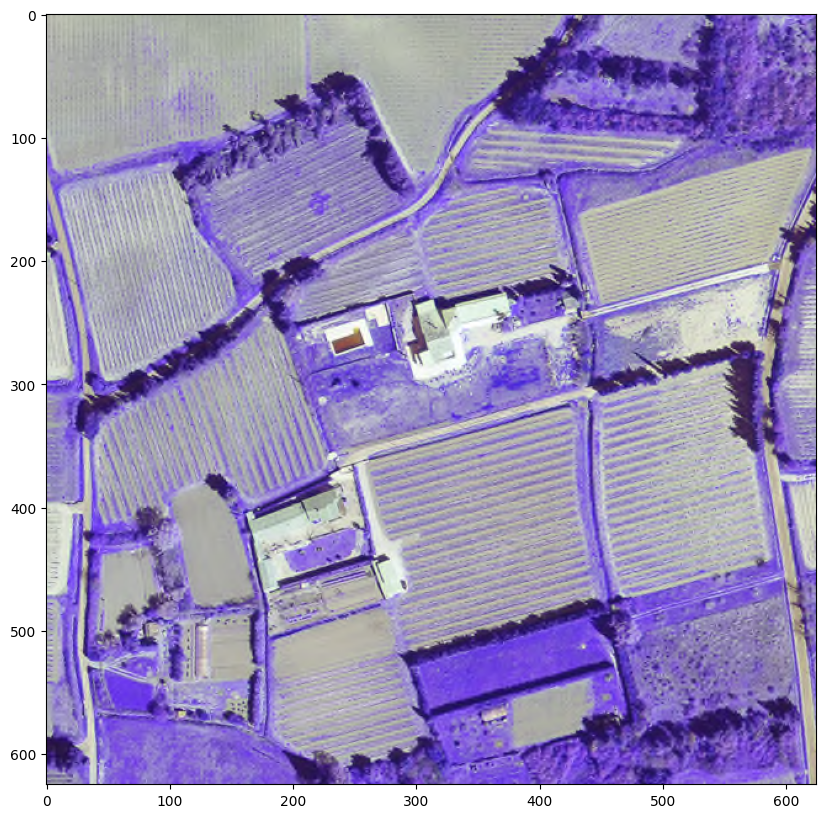

In [9]:
# Convert to HSV color space and show image
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img_bgr)
plt.show()

Filter

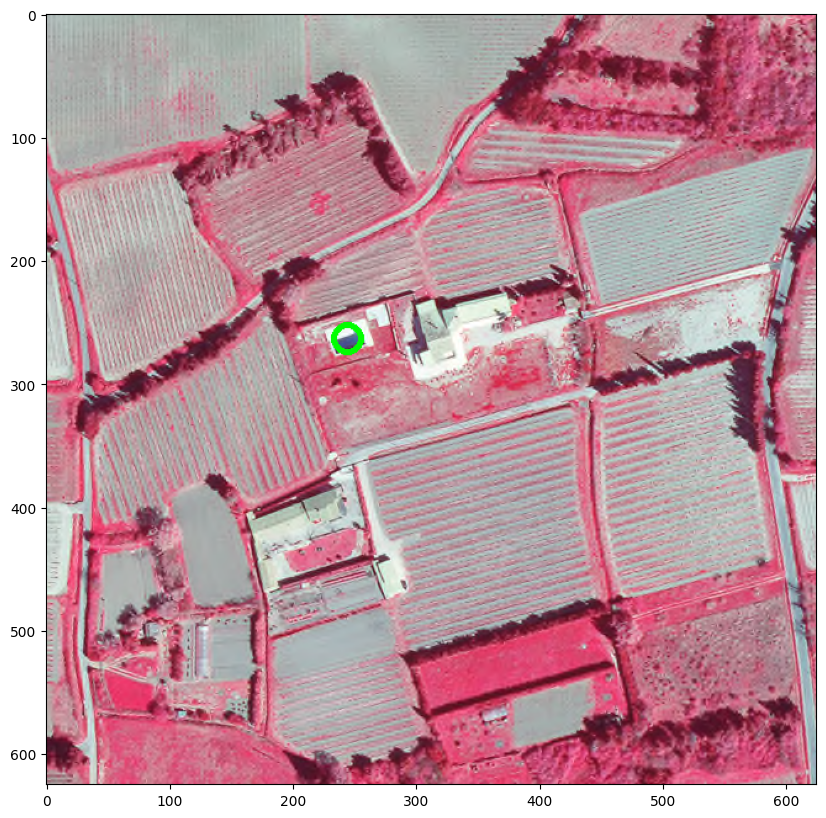

In [10]:
def detect_pools(image):
    # Convert to HSV color space for easier color filtering
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Yellow color range
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Orange color range
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([20, 255, 255])

    # Red color range (might need two parts)
    # Lower red
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    # Upper red
    lower_red2 = np.array([170, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for each color
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine masks
    mask = cv2.bitwise_or(mask_yellow, mask_orange)
    mask = cv2.bitwise_or(mask, mask_red1)
    mask = cv2.bitwise_or(mask, mask_red2)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter for rectangular or circular shapes
    for cnt in contours:
        # Approximate the contour to a polygon
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

        # Check for rectangular shapes
        if len(approx) == 4:
            cv2.drawContours(image, [approx], 0, (0, 255, 0), 3)  # Green rectangle

        # Check for circular shapes
        elif len(approx) > 10:
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(image, center, radius, (0, 255, 0), 3)  # Green circle

    return image

img_copy = np.copy(img)
result = detect_pools(img_copy)
if result is not None:
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.show()

#### Let's build the algorithm

In [11]:
def detect_swimming_pools(image):
    # Convert to HSV color space for easier color filtering
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Yellow color range
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Orange color range
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([20, 255, 255])

    # Red color range (might need two parts)
    # Lower red
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    # Upper red
    lower_red2 = np.array([170, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for each color
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine masks
    mask = cv2.bitwise_or(mask_yellow, mask_orange)
    mask = cv2.bitwise_or(mask, mask_red1)
    mask = cv2.bitwise_or(mask, mask_red2)

    pool_centers = []
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter for rectangular or circular shapes
    for cnt in contours:
        # Approximate the contour to a polygon
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

        # Check for rectangular or circular shapes and get center
        if len(approx) == 4 or len(approx) > 10:
            M = cv2.moments(cnt)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                pool_centers.append((cx, cy))

        elif len(approx) > 10:
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            pool_centers.append((int(x), int(y)))

    return pool_centers

In [12]:
def process_and_save_coordinates(img, nb_split, original_width, original_height):
    img_split = split_image(img, nb_split)
    all_pool_centers = []

    for i in range(nb_split):
        for j in range(nb_split):
            split_img = img_split[i * nb_split + j]
            split_pool_centers = detect_swimming_pools(split_img)

            # Adjust coordinates based on split offset
            split_x_offset = j * original_width // nb_split
            split_y_offset = i * original_height // nb_split
            adjusted_centers = [(x + split_x_offset, y + split_y_offset) for x, y in split_pool_centers]

            all_pool_centers.extend(adjusted_centers)

    return all_pool_centers

# Example usage
original_width, original_height, _ = full_img.shape
pool_centers = process_and_save_coordinates(full_img, NB_SPLIT, original_width, original_height)
print(pool_centers)

[(245, 265), (3740, 429), (3778, 437), (4219, 66), (4658, 366), (4645, 109), (4811, 97), (4728, 63), (4635, 39), (5146, 566), (5602, 525), (5220, 497), (5066, 422), (7153, 623), (7056, 579), (7188, 544), (7992, 530), (7664, 517), (7627, 506), (8711, 553), (8506, 551), (8554, 539), (8585, 533), (8732, 482), (8873, 589), (2841, 1229), (2832, 1229), (4884, 1149), (5123, 1083), (5235, 870), (5586, 834), (5545, 821), (5388, 799), (5457, 740), (6128, 1021), (5887, 1003), (6247, 968), (6307, 975), (6271, 968), (6335, 966), (6327, 753), (6378, 686), (7250, 1017), (7189, 911), (7366, 817), (7177, 792), (7282, 738), (7153, 625), (7931, 1108), (7676, 1100), (7733, 1046), (7791, 942), (7824, 785), (8135, 1100), (8580, 1085), (8623, 1027), (8746, 1008), (8735, 1006), (8521, 988), (8284, 945), (8717, 884), (8919, 1137), (8948, 1098), (9003, 1060), (8906, 917), (9496, 706), (4843, 1559), (4847, 1554), (5223, 1673), (5620, 1344), (5629, 1342), (5872, 1267), (6783, 1277), (7967, 1509), (8485, 1665), (8

In [22]:
print(original_width)

10000


In [13]:
print(len(pool_centers))

501


In [19]:
def pixel_to_local(x_pixel, y_pixel, img_width, img_height):
    top_left = (830000.00, 6355000.00)  # pixel (0,0)
    bottom_right = (835000.00, 6350000.00)  # pixel (img_width, img_height)

    # Calculate scale factors
    x_scale = (bottom_right[0] - top_left[0]) / img_width
    y_scale = (bottom_right[1] - top_left[1]) / img_height

    # Convert pixel to local coordinates
    x_local = top_left[0] + x_pixel * x_scale
    y_local = top_left[1] + y_pixel * y_scale

    return x_local, y_local

In [20]:
from pyproj import Proj, transform

lambert_proj = Proj(init='epsg:2154')   # Lambert-93 projection
wgs84_proj = Proj(init='epsg:4326')

# Function to convert Lambert-93 to WGS84
def lambert_to_wgs84(x_lambert, y_lambert):
    lon, lat = transform(lambert_proj, wgs84_proj, x_lambert, y_lambert)
    return lon, lat



4.632087777099993 44.28055520871921


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-20-826d0609c370>:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(lambert_proj, wgs84_proj, x_la

In [23]:
img_width, img_height = 10000, 10000

wgs84_pool_centers = []
for x_pixel, y_pixel in pool_centers:
    x_local, y_local = pixel_to_local(x_pixel, y_pixel, img_width, img_height)
    lon, lat = lambert_to_wgs84(x_local, y_local)
    wgs84_pool_centers.append((lon, lat))

print(wgs84_pool_centers)


<ipython-input-20-826d0609c370>:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(lambert_proj, wgs84_proj, x_lambert, y_lambert)


[(4.630495129621491, 44.28073640490267), (4.652364265341305, 44.27967150517375), (4.652601221783045, 44.27963192924186), (4.65541205359072, 44.2812597233706), (4.6581222502389075, 44.27986838081968), (4.658074632471444, 44.28102601501273), (4.659115942202463, 44.281064318959565), (4.658600550456775, 44.28122515357848), (4.658021205648033, 44.28134193441389), (4.661152386197012, 44.27892229640556), (4.664013815309257, 44.27906357263245), (4.66162495830564, 44.27922576375623), (4.660670300961462, 44.27957781549708), (4.673715017329059, 44.278475089745015), (4.673113333714193, 44.278682323729946), (4.673944717522594, 44.27882722008598), (4.6789821622147985, 44.27881339547311), (4.6769295747753326, 44.27890325738359), (4.676699300575837, 44.278956289010914), (4.683482295431282, 44.278641011567636), (4.682198620025836, 44.278669672222875), (4.68250085221728, 44.27871906510631), (4.6826958105161705, 44.27874308993641), (4.683623304049056, 44.27895846812403), (4.684492111681243, 44.2784634781